# CS794 Question 4

### Imports

In [ ]:
from PIL import Image
import numpy as np
from numpy.linalg import svd, norm
import os
import matplotlib.pyplot as plt

### Prepare the Data

In [ ]:
!wget http://www.svcl.ucsd.edu/projects/background_subtraction/JPEGS.tar.gz
!tar -xzf JPEGS.tar.gz
%cd JPEGS
%cd birds

--2023-11-30 20:48:13--  http://www.svcl.ucsd.edu/projects/background_subtraction/JPEGS.tar.gz
Resolving www.svcl.ucsd.edu (www.svcl.ucsd.edu)... 169.228.63.130
Connecting to www.svcl.ucsd.edu (www.svcl.ucsd.edu)|169.228.63.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67365612 (64M) [application/x-gzip]
Saving to: ‘JPEGS.tar.gz’

JPEGS.tar.gz        100%[===================>]  64.24M  20.0MB/s    in 4.2s    

2023-11-30 20:48:17 (15.2 MB/s) - ‘JPEGS.tar.gz’ saved [67365612/67365612]

/content/JPEGS/birds/JPEGS
/content/JPEGS/birds/JPEGS/birds


In [ ]:
def form_matrixA():
    # Get the current directory
    path = os.getcwd()
    # print(path)

    # Get a list of image file names in the directory
    image_files = [f for f in os.listdir(path) if f.endswith('.jpg')]
    sort_image_files = sorted(image_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
    # print(sort_image_files)

    # Initialize the matrix A
    A = np.zeros((37752, len(sort_image_files)))

    # Iterate through each image file
    for i, image_file in enumerate(sort_image_files):
        # Load the image
        img = Image.open(os.path.join(path, image_file))
        # print(np.asarray(img))

        # Convert the image to grayscale
        img_gray = img.convert('L')

        # Invert the pixel values
        img_inverted = Image.eval(img_gray, lambda x: 255 - x)

        # Flatten the image matrix to a 1D array and insert into matrix A
        A[:, i] = np.array(img_inverted).flatten()

    return A

### ADMM (Alternating Direction Method of Multipliers)

In [ ]:
# Compute the proximal gradient for the func t||?||_1; same as prox_psi
def prox_l1(x,t):
    shrunk_columns = np.sign(x) * np.maximum(0, np.abs(x) - t)
    return shrunk_columns


def prox_nuclear_norm(x,t):
    # x is a list and t is a value
    result_diagonal = np.maximum(x - t, 0)
    return result_diagonal

In [ ]:
# gamma is the weight used on the nuclear-norm term
# rho is the inverse-step-size
def admm_rank_sparsity(A, gamma, rho, maxit, primtol, dualtol):
    # Initilization
    # L corresponds to x, M corresponds to y, Y corresponds to Lambda/mu
    L = np.zeros_like(A)
    #print(L.shape)
    M = np.zeros_like(A)
    Y = np.zeros_like(A)
    numit = 0

    ### For SVD econ/wide option: svd(..., full_matrices=False)
    for i in range(maxit):
        # Update steps
        M_prev = M.copy()

        L = (- M) + A - (Y / rho)
        L = prox_l1(L, 1 / rho)

        M = (-L) + A - (Y / rho)
        U, Sigma, VT = svd(M, full_matrices=False)
        S = np.diag(Sigma)
        #print(S)
        Sigma = prox_nuclear_norm(S, gamma / rho)
        M = U @ Sigma @ VT

        Y = Y + rho * (M + L - A)

        # Termination Condition
        primal_residual = norm(L + M - A)
        dual_residual = rho * norm(M - M_prev)
        if primal_residual < primtol and dual_residual < dualtol:
            numit = i
            break

        # print(f"Iteration {i}; primal_residual: {primal_residual}; dual_residual: {dual_residual}")
    return L, M, Y, numit

### Plot

In [ ]:
def plot_images(L, M):
    frame_num = range(1, 72, 10)
    for i in frame_num:
        # Reshape L and M
        L_reshape = np.round(L[:,i-1].reshape(156, 242))
        M_reshape = np.round(M[:,i-1].reshape(156, 242))

        foreground = np.clip(L_reshape, 0, 255).astype(np.uint8)
        background = np.clip(M_reshape, 0, 255).astype(np.uint8)

        # foreground_rgb = np.stack((foreground,) * 3, axis= - 1)
        # background_rgb = np.stack((background,) * 3, axis= - 1)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(foreground, cmap = "gray")
        plt.title(f"Foreground of frame {i}")

        plt.subplot(1, 2, 2)
        plt.imshow(background, cmap = "gray")
        plt.title(f"Background of frame {i}")
        plt.show()

### Driver

In [ ]:
def driver():
    # Initialization
    rho = 1
    gamma = 300
    maxit = 20000
    primtol = 1e-3
    dualtol = 1e-3
    A = form_matrixA()

    # Call ADMM
    L, M, Y, numit = admm_rank_sparsity(A, gamma, rho, maxit, primtol, dualtol)

    # Plot the foreground and background
    plot_images(L, M)

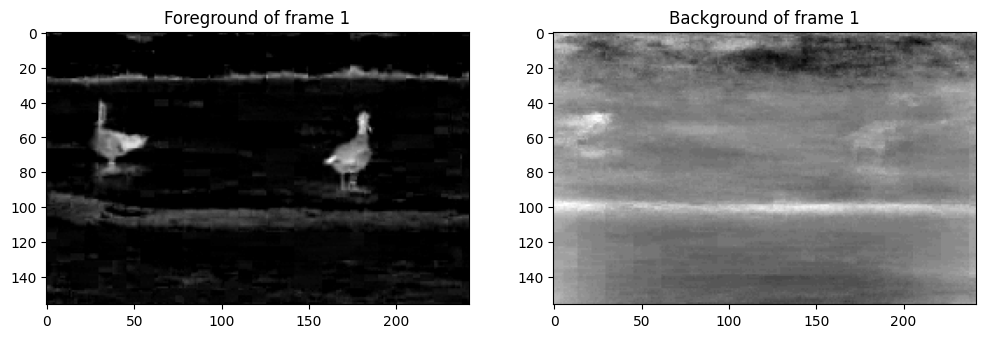

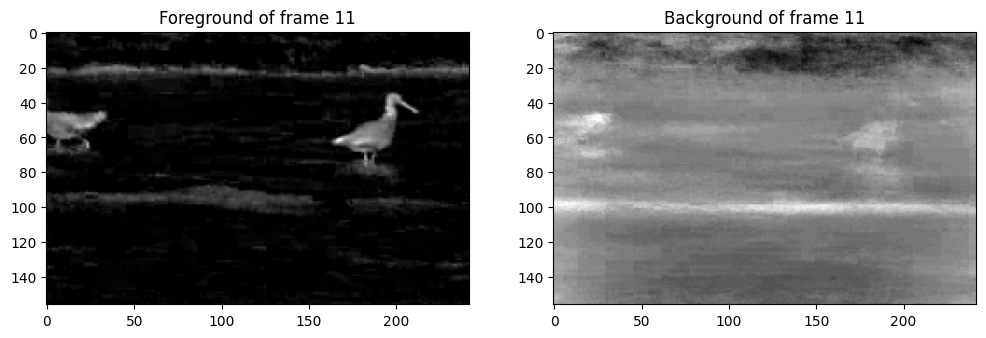

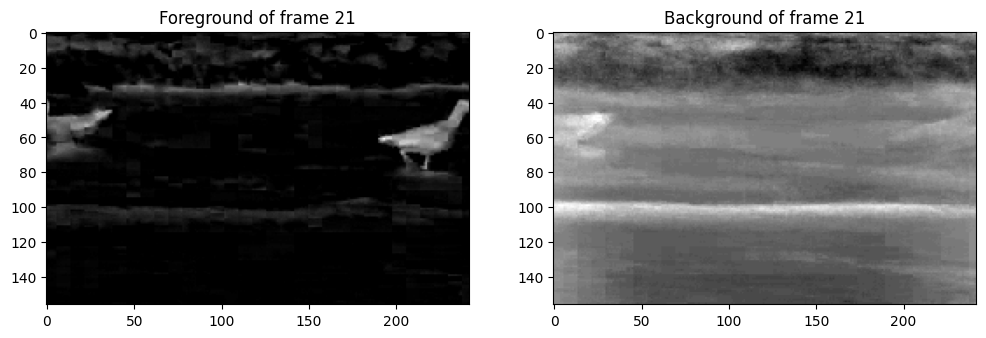

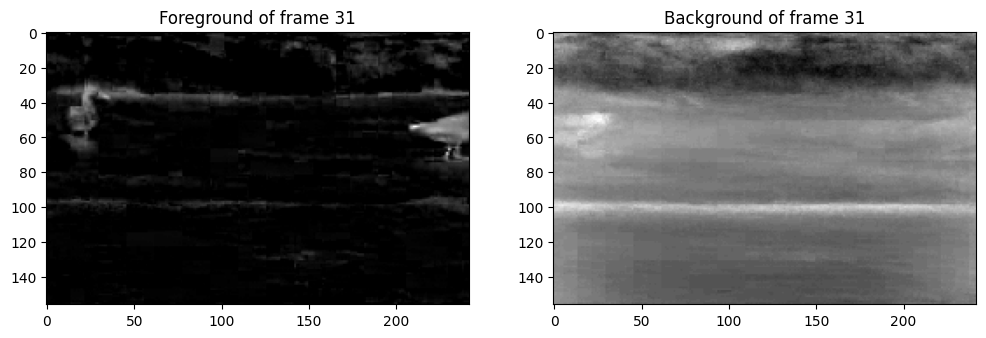

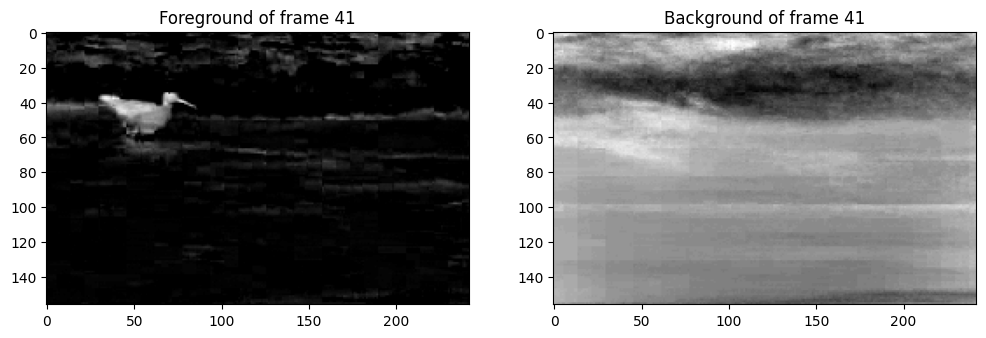

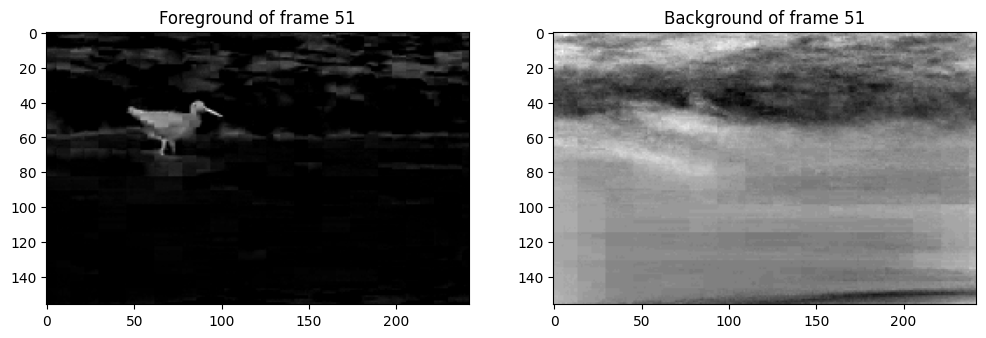

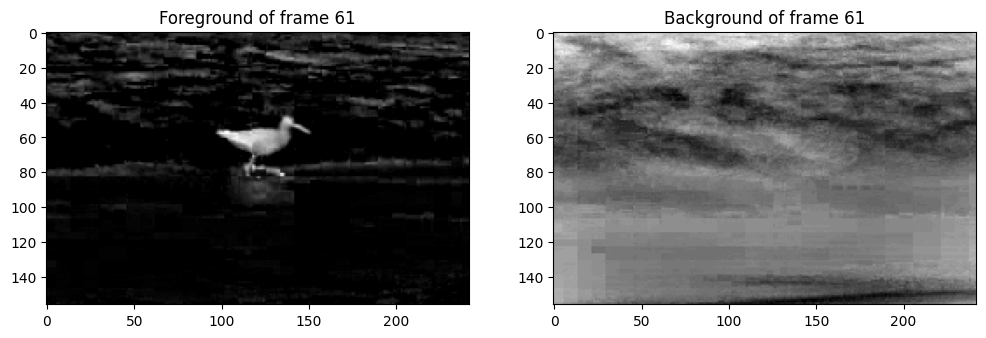

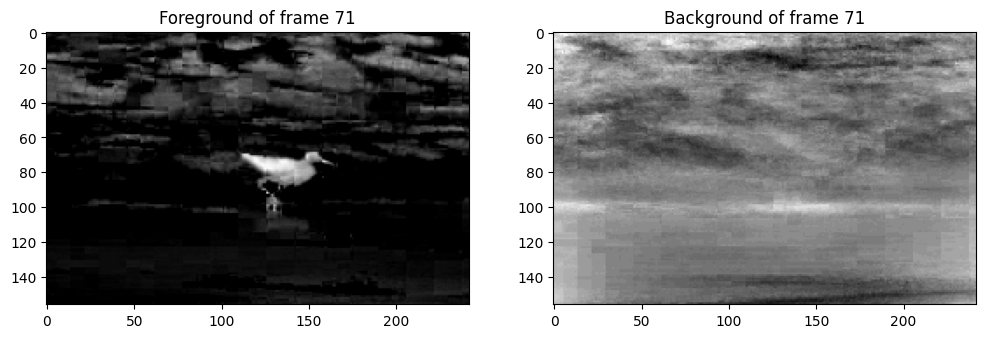

In [ ]:
driver()